In [33]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from math import ceil

In [34]:
#Reading data files
trips = {}
trips['trip1_acc'] = pd.read_csv("data/1/Accelerometer.csv")
trips['trip1_lac'] = pd.read_csv("data/1/Linear_Acceleration.csv")
trips['trip1_gyr'] = pd.read_csv("data/1/Gyrometer.csv")
trips['trip1_mag'] = pd.read_csv("data/1/Magnetometer.csv")
trips['trip1_lbl'] = pd.read_csv("data/1/Truth.csv")

trips['trip2_acc'] = pd.read_csv("data/2/Accelerometer.csv")
trips['trip2_lac'] = pd.read_csv("data/2/Linear_Acceleration.csv")
trips['trip2_gyr'] = pd.read_csv("data/2/Gyrometer.csv")
trips['trip2_mag'] = pd.read_csv("data/2/Magnetometer.csv")
trips['trip2_lbl'] = pd.read_csv("data/2/Truth.csv")

trips['trip3_acc'] = pd.read_csv("data/3/Accelerometer.csv")
trips['trip3_lac'] = pd.read_csv("data/3/Linear_Acceleration.csv")
trips['trip3_gyr'] = pd.read_csv("data/3/Gyrometer.csv")
trips['trip3_mag'] = pd.read_csv("data/3/Magnetometer.csv")
trips['trip3_lbl'] = pd.read_csv("data/3/Truth.csv")

trips['trip4_acc'] = pd.read_csv("data/4/Accelerometer.csv")
trips['trip4_lac'] = pd.read_csv("data/4/Linear_Acceleration.csv")
trips['trip4_gyr'] = pd.read_csv("data/4/Gyrometer.csv")
trips['trip4_mag'] = pd.read_csv("data/4/Magnetometer.csv")
trips['trip4_lbl'] = pd.read_csv("data/4/Truth.csv")

In [35]:
trips['trip1_acc'].head(5)

,timestamp,uptimeNanos,x,y,z
0,14/05/2016 10:54:33,11537640270059,-0.161602,0.120174,9.596758
1,14/05/2016 10:54:33,11537650128140,-0.122628,0.315638,9.425655
2,14/05/2016 10:54:33,11537659894659,-0.178777,0.330180,9.445955
3,14/05/2016 10:54:33,11537679549779,0.016043,0.038759,9.528445
4,14/05/2016 10:54:33,11537699204899,0.141716,-0.162492,9.756854


In [36]:
# Irrelevant timestamp column dropping
# Also, determine smallest and largest window sizes for the events
min_window = 1000000
max_window = 0

for name,trip in trips.items():
    if 'timestamp' in trip.columns:
        trip.drop(['timestamp'], axis=1, inplace=True)
    
    if 'uptimeNanos' in trip.columns:
        uptimeNanos = np.array(trip['uptimeNanos'])
        timeInSec = (uptimeNanos - uptimeNanos[0])/1000000000
        trip['timeInSec'] = timeInSec
        trip.drop(['uptimeNanos'], axis=1, inplace=True)
        
    if 'event' in trip.columns:
        maxW = max(trip.finish - trip.start)
        minW = min(trip.finish - trip.start)
        
        if maxW > max_window:
            max_window = maxW
        if minW < min_window:
            min_window = minW

In [37]:
trips['trip1_acc'].head(5)

,x,y,z,timeInSec
0,-0.161602,0.120174,9.596758,0.000000
1,-0.122628,0.315638,9.425655,0.009858
2,-0.178777,0.330180,9.445955,0.019625
3,0.016043,0.038759,9.528445,0.039280
4,0.141716,-0.162492,9.756854,0.058935


In [38]:
# Rounding of the window size to the ceil of the time difference between start and finish of the event 
print("Minimum event duration: ", min_window, "s   Minimum Window Size: " , ceil(min_window), "s")
min_window = ceil(min_window)
print("Maximum event duration: ", max_window, "s   Maximum Window Size: " , ceil(max_window), "s")
max_window = ceil(max_window)

Minimum event duration:  1.5999999999999979 s   Minimum Window Size:  2 s
Maximum event duration:  4.899999999999977 s   Maximum Window Size:  5 s


In [39]:
# Storing the indices of 1sec frames 
allTripPerSecIndex = {}
for name,trip in trips.items():
    if 'event' not in trip.columns:
        tmpFrame = pd.DataFrame(columns=['perSecIndex'])
        count = 0
        for i in range(0,len(trip)-1,1):
            if trip['timeInSec'][i]-count > 1:
                tmpFrame = tmpFrame.append({'perSecIndex':i-1},ignore_index=True)
                count = count + 1
        allTripPerSecIndex[name+'_perSecIndex'] = tmpFrame

In [40]:
# Function getFeatureNames
# Input:
#     s = sensor_name
#     w = window_size
# Output:
#     l = [feature names as list, feature name as dictionary]

# params = [Mean, Median, Std Deviation, Mean Abs Deviation, Min, Max, Tendency]
def getFeatureNames( s, w ):
    l = []
    c = []
    d = {}
    params = ['mean','median','sd','td']
    
    for i in range(1,w+1):
        for j in range(0,len(params),1):
            v1 = s + '_' + params[j] + '_x' + str(i)
            v2 = s + '_' + params[j] + '_y' + str(i)
            v3 = s + '_' + params[j] + '_z' + str(i)
            
            if params[j] != 'td':
                c.append(v1)
                c.append(v2)
                c.append(v3)
                
                d[v1] = 0.0
                d[v2] = 0.0
                d[v3] = 0.0
            else:
                if i != w:                    
                    c.append(v1)
                    c.append(v2)
                    c.append(v3)
                    
                    d[v1] = 0.0
                    d[v2] = 0.0
                    d[v3] = 0.0
    l.append(c)
    l.append(d)
    
    return l

In [41]:
# Considering window_size = 2
w = 3
dataSensorwise = {}
for name,tripIndex in allTripPerSecIndex.items():
    i = 0
    j = w
    end = len(tripIndex)
    l = getFeatureNames(name[6:len(name)-12],w)
    tripFeature = pd.DataFrame(columns=l[0])
    tripRawData = trips[name[:len(name)-12]]
    
    featureVector = l[1]   
    key_mean = name[6:len(name)-12] + '_mean_'
    key_median = name[6:len(name)-12] + '_median_'
    key_sd = name[6:len(name)-12] + '_sd_'
    key_td = name[6:len(name)-12] + '_td_'
    setLastInd = 0
    
    while(j<=end):    
        lastInd = setLastInd
        frameCount = 1
        
        for k in range(i,j,1):            
            ind = tripIndex.perSecIndex.values[k]
            
            featureVector[key_mean + 'x' + str(frameCount)] = tripRawData.x[lastInd:ind+1].mean()
            featureVector[key_mean + 'y' + str(frameCount)] = tripRawData.y[lastInd:ind+1].mean()
            featureVector[key_mean + 'z' + str(frameCount)] = tripRawData.z[lastInd:ind+1].mean()
            
            featureVector[key_median + 'x' + str(frameCount)] = tripRawData.x[lastInd:ind+1].median()
            featureVector[key_median + 'y' + str(frameCount)] = tripRawData.y[lastInd:ind+1].median()
            featureVector[key_median + 'z' + str(frameCount)] = tripRawData.z[lastInd:ind+1].median()
            
            featureVector[key_sd + 'x' + str(frameCount)] = tripRawData.x[lastInd:ind+1].std()
            featureVector[key_sd + 'y' + str(frameCount)] = tripRawData.y[lastInd:ind+1].std()
            featureVector[key_sd + 'z' + str(frameCount)] = tripRawData.z[lastInd:ind+1].std()                       
            
            # Set td only if it is not first frame
            if frameCount != 1:
                featureVector[key_td + 'x' + str(frameCount-1)] = featureVector[key_mean + 'x' + str(frameCount)]/featureVector[key_mean + 'x' + str(frameCount-1)]
                featureVector[key_td + 'y' + str(frameCount-1)] = featureVector[key_mean + 'y' + str(frameCount)]/featureVector[key_mean + 'y' + str(frameCount-1)]
                featureVector[key_td + 'z' + str(frameCount-1)] = featureVector[key_mean + 'z' + str(frameCount)]/featureVector[key_mean + 'z' + str(frameCount-1)]  
            else:
                setLastInd = ind;
                
            frameCount = frameCount + 1
        
        tripFeature = tripFeature.append(featureVector,ignore_index=True) 
        i = i + 1
        j = j + 1
    dataSensorwise[name[:len(name)-12]] = tripFeature       
            

In [42]:
# Merging all sensor attribute vectors into a common attribute vector
dataConsolidated = {}
dataConsolidated['trip1'] = pd.DataFrame()
dataConsolidated['trip2'] = pd.DataFrame()
dataConsolidated['trip3'] = pd.DataFrame()
dataConsolidated['trip4'] = pd.DataFrame()

for name, vec in dataSensorwise.items():
    if name[:5] == 'trip1':
        dataConsolidated['trip1'] = pd.concat([dataConsolidated['trip1'],vec],axis=1)
    elif name[:5] == 'trip2':
        dataConsolidated['trip2'] = pd.concat([dataConsolidated['trip2'],vec],axis=1)
    elif name[:5] == 'trip3':
        dataConsolidated['trip3'] = pd.concat([dataConsolidated['trip3'],vec],axis=1)
    else:
        dataConsolidated['trip4'] = pd.concat([dataConsolidated['trip4'],vec],axis=1)

In [43]:
# Appending the column with key in label frame
for name, trip in trips.items():
    if name[6:len(name)] == 'lbl':
        trip['key'] = 0

In [44]:
# Appending the column with key in data frame
for name,tripDataConsolidated in dataConsolidated.items():
    tripDataConsolidated['key'] = 0
    tripDataConsolidated['startTime'] = np.arange(start=0,step=1, stop=len(tripDataConsolidated))
    tripDataConsolidated['endTime'] = np.arange(start=3,step=1, stop=len(tripDataConsolidated)+3)
    dataConsolidated[name] = pd.merge(tripDataConsolidated,trips[name+'_lbl'],on='key',how='inner')  
    dataConsolidated[name].drop(dataConsolidated[name][(dataConsolidated[name].start<dataConsolidated[name].startTime) |
                                 (dataConsolidated[name].start>=dataConsolidated[name].endTime)].index,inplace=True)
    dataConsolidated[name].drop(['key','start','finish','startTime','endTime'],axis=1,inplace=True)
    dataConsolidated[name].reset_index(drop=True, inplace=True)

In [45]:
dataConsolidated['trip1']

,acc_mean_x1,acc_mean_y1,acc_mean_z1,acc_median_x1,acc_median_y1,acc_median_z1,acc_sd_x1,acc_sd_y1,acc_sd_z1,acc_td_x1,...,mag_mean_x2,mag_mean_y2,mag_mean_z2,mag_median_x2,mag_median_y2,mag_median_z2,mag_sd_x2,mag_sd_y2,mag_sd_z2,event
0,0.014650,0.066562,9.655590,0.034021,0.053366,9.657350,0.077052,0.168886,0.086906,3.169775,...,-6.199080e-08,40.883544,-8.609357,-6.233677e-08,40.850421,-8.641632,4.194727e-07,0.235474,0.739957,Non-Aggressive
1,0.078522,0.316835,9.694672,0.079507,0.284995,9.698062,0.054473,0.171353,0.060777,1.522992,...,7.874161e-09,41.196739,-8.286252,1.706940e-08,40.964260,-8.415723,4.609335e-07,0.609669,1.255949,Non-Aggressive
2,0.159810,1.165243,9.829725,0.147632,1.191789,9.835896,0.130797,0.175204,0.120871,0.739213,...,6.682004e-09,41.774731,-5.815260,8.713869e-09,41.957758,-4.968275,4.540516e-07,0.562748,1.876891,Non-Aggressive
3,0.100703,-0.028826,9.643615,0.188691,-0.089057,9.642485,1.002943,0.564868,0.452935,0.587161,...,2.475529e-09,41.824586,-9.252046,3.376044e-08,41.805582,-9.281508,3.990232e-07,0.212730,0.284902,Aggressive Right Curve
4,0.033653,-0.082215,9.637729,0.041861,-0.042545,9.684040,0.549383,0.437339,0.460473,6.138534,...,-3.215505e-08,41.316620,-10.111684,2.910383e-09,41.672394,-9.559412,4.252463e-07,0.831310,1.120813,Aggressive Right Curve
5,0.365781,-1.684385,9.636445,0.319423,-1.802917,9.811771,1.064238,0.815442,0.595867,3.969304,...,-3.024186e-08,38.768145,-13.504545,-5.355105e-08,38.960941,-12.915261,5.599219e-07,2.424975,2.923671,Aggressive Right Curve
6,0.666953,-0.372696,9.706165,0.814272,-0.354093,9.760743,0.592627,0.813245,0.470513,1.287014,...,-1.017363e-08,18.776981,-9.228013,-2.095476e-09,18.312304,-9.349053,2.323463e-07,2.221868,0.825098,Non-Aggressive
7,1.054699,0.138012,9.567707,1.044380,0.152590,9.600371,0.292321,0.511274,0.213378,0.724687,...,8.112870e-10,19.126783,-9.873841,2.793968e-09,18.928760,-9.817892,4.193798e-08,1.162468,0.349811,Non-Aggressive
8,0.478742,0.521445,9.656359,0.426795,0.483552,9.728072,0.292020,0.420922,0.236799,0.775768,...,-3.274226e-10,21.827155,-9.758399,2.910383e-09,21.881598,-9.785820,1.528667e-07,2.201475,0.379489,Non-Aggressive
9,-0.077173,-0.159991,9.611717,0.027837,-0.225233,9.598262,1.060918,0.776749,0.581559,-0.979149,...,2.792009e-08,40.877101,-9.161971,1.280569e-08,40.954728,-8.452049,4.436754e-07,0.438633,1.818298,Aggressive Right Curve


In [46]:
# Preparing the final data frame, that will be utilized for ML models
dataset = pd.DataFrame()
for name, trip in dataConsolidated.items():
    dataset = pd.concat([dataset, dataConsolidated[name]], axis=0)
dataset = dataset.reset_index(drop=True)

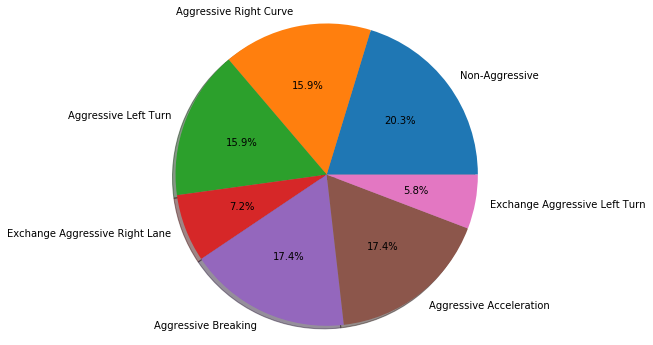

In [47]:
# Showing the distribution of various rash driving events in the dataset
eventDist = dataset.event.value_counts()
sizes = [eventDist[0],eventDist[4],eventDist[3],eventDist[5],eventDist[2],eventDist[1],eventDist[6]]

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.pie(sizes, labels=dataset.event.unique(), autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

In [48]:
# Labelling as 1 - Rash driving and 0 - Not Rash driving
dataset
dataset['label'] = [0 if x =='Non-Aggressive' else 1 for x in dataset['event']]
dataset.drop('event', axis=1, inplace=True)

In [49]:
# Split the data in 70:30 ratio for train and test
X = dataset.loc[:, dataset.columns != 'label']
Y = dataset.loc[:, dataset.columns == 'label']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

model = XGBClassifier()
model = model.fit(x_train,y_train)

/home/vishu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vishu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


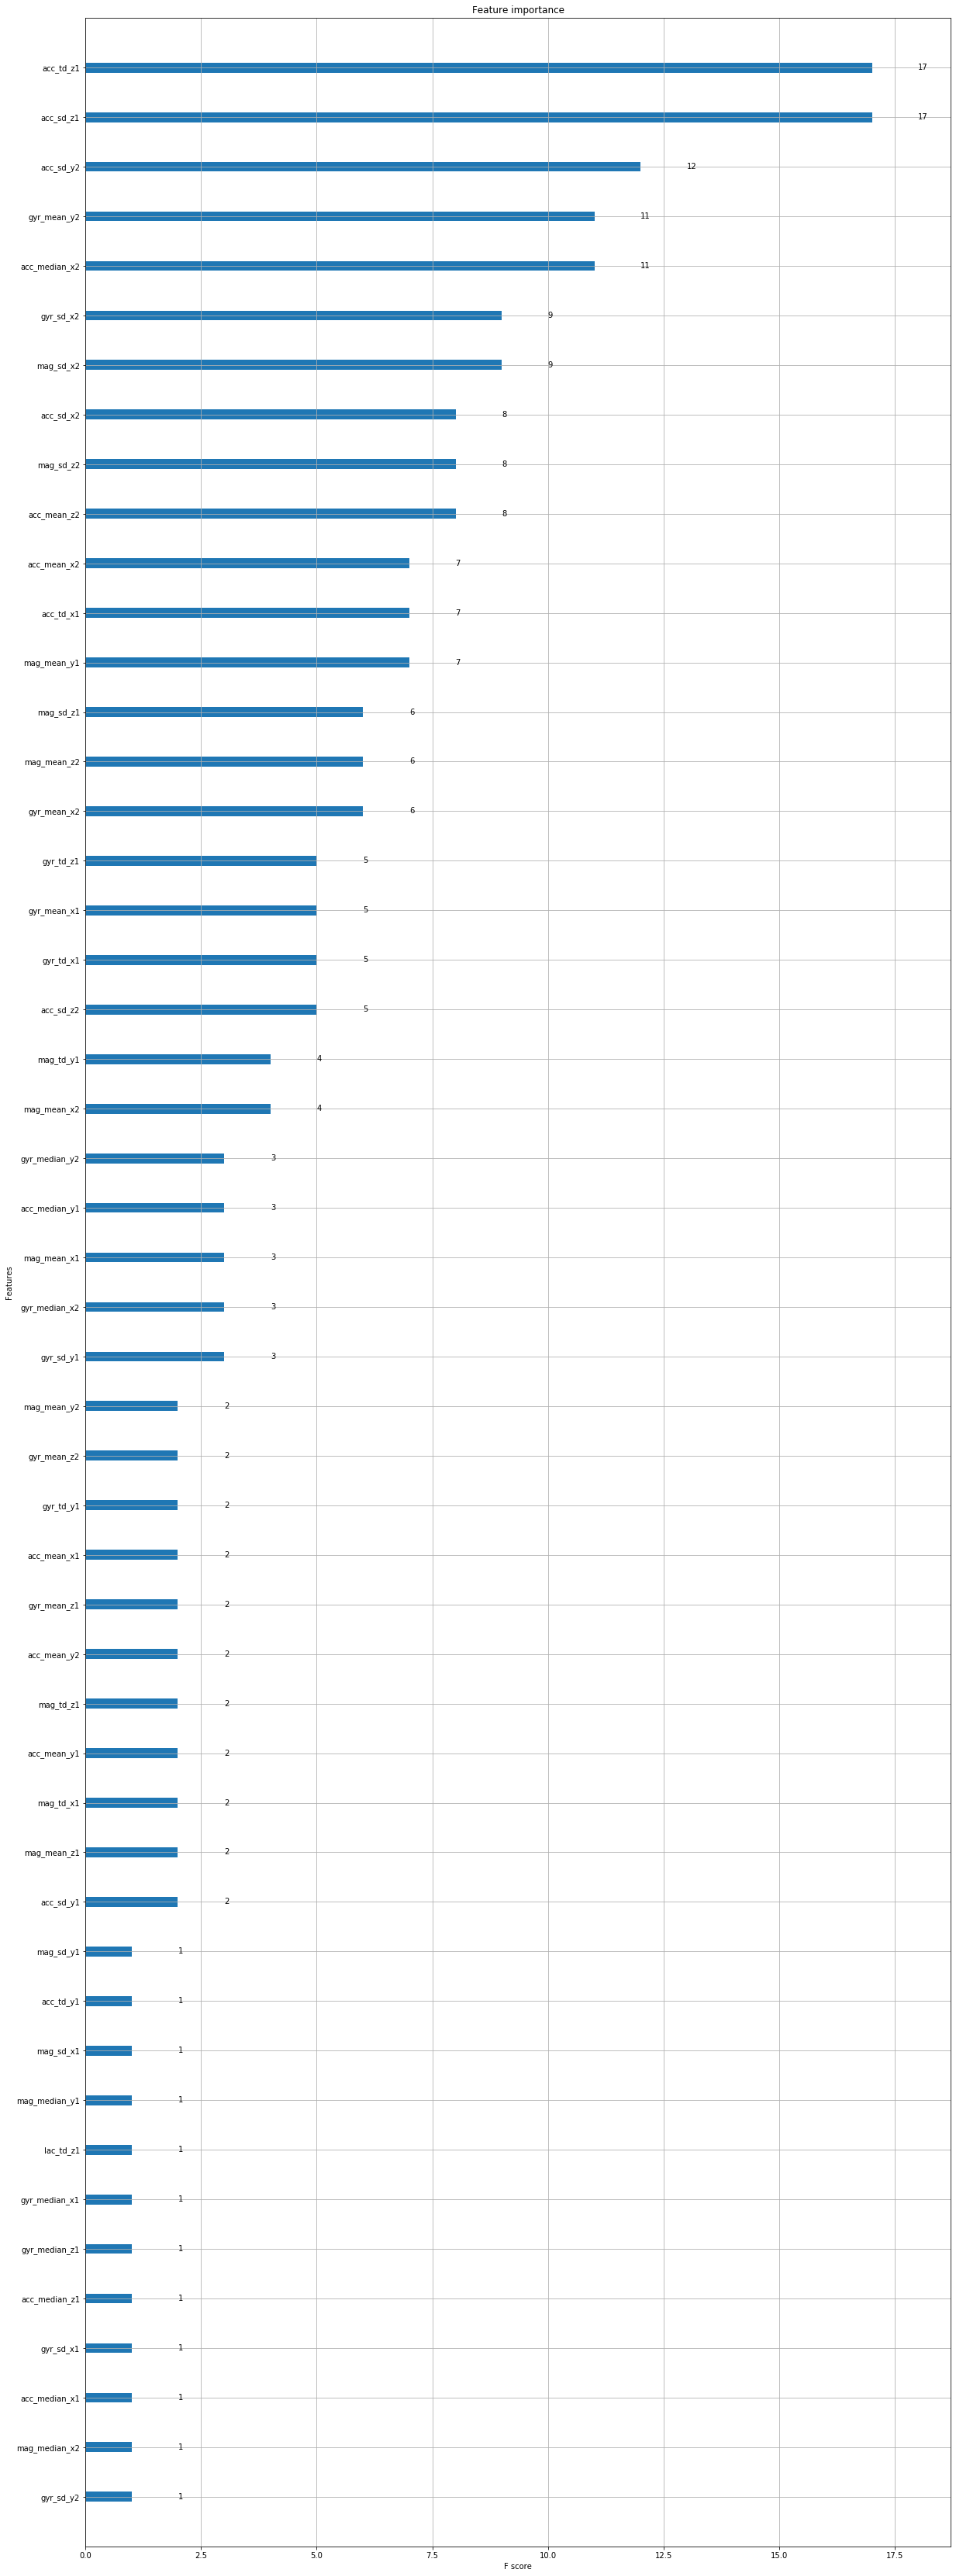

In [50]:
fig1, ax1 = plt.subplots(figsize=(20,60))
plot_importance(model,ax=ax1)

In [51]:
model.score(x_test,y_test)

0.8571428571428571

In [53]:
y_predicted = model.predict(x_test)
print(confusion_matrix(y_test, y_predicted))

[[ 6  5]
 [ 4 48]]


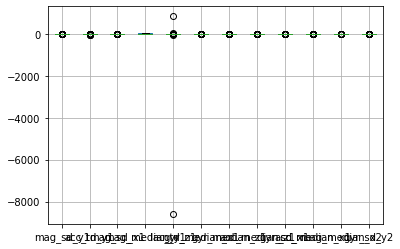

In [54]:
# This shows the proof for point-7 above

dataset.boxplot([ 'acc_mean_z1','acc_median_y1','acc_median_z1','acc_sd_x1','acc_sd_y1','acc_td_y1','acc_mean_x2','acc_mean_y2',
'acc_median_y2','acc_median_z2','acc_sd_z2','acc_td_y2','gyr_mean_x1','gyr_mean_y1','gyr_median_y1','gyr_median_z1','gyr_sd_z1','gyr_td_x1','gyr_td_y1','gyr_mean_x2','gyr_median_x2','gyr_median_z2','gyr_sd_x2','gyr_sd_y2',
'gyr_td_x2','gyr_td_y2','gyr_td_z2','gyr_mean_x3','gyr_mean_y3','gyr_median_x3','gyr_median_y3','gyr_median_z3',
'gyr_sd_y3','gyr_sd_z3','mag_mean_x1','mag_median_y1','mag_median_z1','mag_sd_x1','mag_sd_y1','mag_td_z1',
'mag_mean_y2','mag_median_y2','mag_median_z2','mag_sd_y2','mag_td_x2','mag_td_z2','mag_mean_x3','mag_mean_z3',
'mag_median_x3','mag_median_z3','mag_sd_y3'])

In [55]:
unimp_cols = ['acc_mean_z1','acc_median_y1','acc_median_z1','acc_sd_x1','acc_sd_y1','acc_td_y1','acc_mean_x2','acc_mean_y2',
'acc_median_y2','acc_median_z2','acc_sd_z2','acc_td_y2','gyr_mean_x1','gyr_mean_y1','gyr_median_y1','gyr_median_z1','gyr_sd_z1','gyr_td_x1','gyr_td_y1','gyr_mean_x2','gyr_median_x2','gyr_median_z2','gyr_sd_x2','gyr_sd_y2',
'gyr_td_x2','gyr_td_y2','gyr_td_z2','gyr_mean_x3','gyr_mean_y3','gyr_median_x3','gyr_median_y3','gyr_median_z3',
'gyr_sd_y3','gyr_sd_z3','mag_mean_x1','mag_median_y1','mag_median_z1','mag_sd_x1','mag_sd_y1','mag_td_z1',
'mag_mean_y2','mag_median_y2','mag_median_z2','mag_sd_y2','mag_td_x2','mag_td_z2','mag_mean_x3','mag_mean_z3',
'mag_median_x3','mag_median_z3','mag_sd_y3']

for i in unimp_cols:
    dataset.drop(i, axis=1, inplace=True)

In [56]:
dataset.columns

Index(['acc_mean_x1', 'acc_mean_y1', 'acc_mean_z1', 'acc_median_y1',
       'acc_sd_x1', 'acc_sd_y1', 'acc_sd_z1', 'acc_td_x1', 'acc_td_z1',
       'acc_mean_x2', 'acc_mean_y2', 'acc_mean_z2', 'acc_median_x2',
       'acc_median_y2', 'acc_median_z2', 'acc_sd_x2', 'acc_sd_y2', 'acc_sd_z2',
       'lac_mean_x1', 'lac_mean_y1', 'lac_mean_z1', 'lac_median_x1',
       'lac_median_y1', 'lac_median_z1', 'lac_sd_x1', 'lac_sd_y1', 'lac_sd_z1',
       'lac_td_x1', 'lac_td_y1', 'lac_mean_x2', 'lac_mean_y2', 'lac_mean_z2',
       'lac_median_x2', 'lac_median_y2', 'lac_median_z2', 'lac_sd_x2',
       'lac_sd_y2', 'lac_sd_z2', 'gyr_mean_x1', 'gyr_mean_y1', 'gyr_mean_z1',
       'gyr_median_y1', 'gyr_sd_y1', 'gyr_sd_z1', 'gyr_td_x1', 'gyr_td_y1',
       'gyr_td_z1', 'gyr_mean_x2', 'gyr_mean_y2', 'gyr_mean_z2',
       'gyr_median_x2', 'gyr_median_y2', 'gyr_median_z2', 'gyr_sd_x2',
       'gyr_sd_z2', 'mag_mean_x1', 'mag_mean_y1', 'mag_mean_z1',
       'mag_median_x1', 'mag_median_z1', 'mag_sd_z1', 'ma

In [57]:
# Split the data in 70:30 ratio for train and test
X = dataset.loc[:, dataset.columns != 'label']
Y = dataset.loc[:, dataset.columns == 'label']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# For Logistic Regression
clf = LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg')
model = clf.fit(x_train, y_train.label)
y_predicted = model.predict(x_test)

In [58]:
model.score(x_test,y_test)

0.8412698412698413

In [59]:
print(confusion_matrix(y_test, y_predicted))

[[ 6  5]
 [ 5 47]]


In [60]:
# Random Forest
model = RandomForestClassifier(n_estimators=150, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(x_train, y_train)

/home/vishu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [61]:
y_predicted = model.predict(x_test)
model.score(x_test,y_test)

0.8571428571428571

In [62]:
print(confusion_matrix(y_test, y_predicted))

[[ 5  6]
 [ 3 49]]


In [63]:
# MLP Classifier
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

mlp = MLPClassifier(hidden_layer_sizes=(20, 15, 10), max_iter=1000)
mlp.fit(x_train, y_train.values.ravel())

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 15, 10), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [64]:
y_predicted = mlp.predict(x_test)
mlp.score(x_test,y_test)

0.8571428571428571

In [65]:
print(confusion_matrix(y_test, y_predicted))

[[ 6  5]
 [ 4 48]]
